# Regression

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Tutorial 2

$\newcommand{\trace}[1]{\operatorname{tr}\left\{#1\right\}}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\inner}[2]{\langle #1, #2 \rangle}$
$\newcommand{\DD}{\mathscr{D}}$
$\newcommand{\grad}[1]{\operatorname{grad}#1}$
$\DeclareMathOperator*{\argmin}{arg\,min}$

Setting up the environment

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## The data set

We will use an old dataset on the price of housing in Boston (see [description](https://archive.ics.uci.edu/ml/datasets/Housing)). The aim is to predict the median value of the owner occupied homes from various other factors. We will use a normalised version of this data, where each row is an example. The median value of homes is given in the first column (the label) and the value of each subsequent feature has been normalised to be in the range $[-1,1]$. Download this dataset from [mldata.org](http://mldata.org/repository/data/download/csv/housing_scale/).

Read in the data using pandas. The following concepts and routines could be useful (note that you may not need all of them):
* [read_csv](http://pandas.pydata.org/pandas-docs/stable/io.html#io-read-csv-table) - use options header and names
* [Indexing and Selecting](http://pandas.pydata.org/pandas-docs/stable/indexing.html)

Check that the data is as expected using ```head()```. Remove the column containing the binary variable 'CHAS' using ```drop```, which should give you a DataFrame with 506 rows (examples) and 13 columns (1 label and 12 features).

In [3]:
# Solution
names = ['medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
data = pd.read_csv('housing_scale.csv', header=None, names=names)
data.head()

,medv,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,24,-1.000000,-0.64,-0.864370,-1,-0.370370,0.155011,0.283213,-0.461594,-1.000000,-0.583969,-0.425532,1.000000,-0.820640
1,21,-0.999528,-1.00,-0.515396,-1,-0.654321,0.095995,0.565396,-0.302076,-0.913043,-0.790076,0.106383,1.000000,-0.591060
2,34,-0.999529,-1.00,-0.515396,-1,-0.654321,0.388772,0.198764,-0.302076,-0.913043,-0.790076,0.106383,0.979475,-0.873068
3,33,-0.999414,-1.00,-0.873900,-1,-0.699588,0.317111,-0.116375,-0.102911,-0.826087,-0.866412,0.297872,0.988552,-0.933223
4,36,-0.998590,-1.00,-0.873900,-1,-0.699588,0.374210,0.056643,-0.102911,-0.826087,-0.866412,0.297872,1.000000,-0.801325


In [4]:
data.drop('chas', axis=1, inplace=True)
data.shape

(506, 13)

## Plotting

Plotting is done using the [matplotlib](http://matplotlib.org/) toolbox. For example:

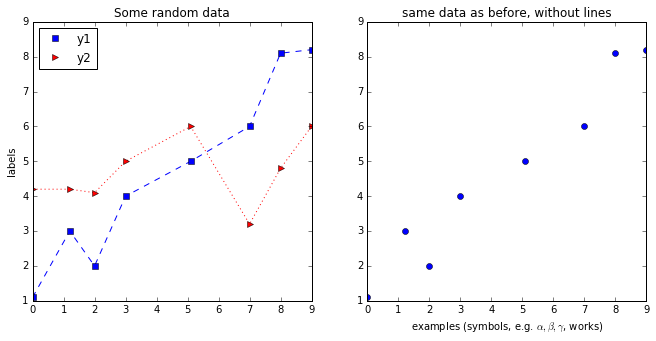

In [5]:
x = [0,1.2,2,3,5.1,7,8,9]
y1 = [1.1,3,2,4,5,6,8.1,8.2]
y2 = [4.2,4.2,4.1,5,6,3.2,4.8,6]
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax.plot(x,y1,'b--')
ax.plot(x,y1,'bs',label='y1')
ax.plot(x,y2,'r:')
ax.plot(x,y2,'r>',label='y2')
ax.set_title('Some random data')
ax.set_ylabel('labels')
ax.legend(loc='upper left', numpoints=1)
ax = fig.add_subplot(122)
ax.plot(x,y1,'bo')
ax.set_title('same data as before, without lines')
ax.set_xlabel(r'examples (symbols, e.g. $\alpha,\beta,\gamma$, works)')


Plot the median value of the property (vertical axis) versus the tax rate (horizontal axis).

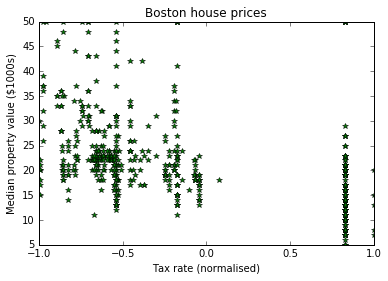

In [6]:
# Solution
plt.plot(data['tax'], data['medv'], 'g*')
plt.title('Boston house prices')
plt.xlabel('Tax rate (normalised)')
plt.ylabel('Median property value ($1000s)')

## Regression without regularization

Implement the sum of squares error function to find the maximum likelihood solution $w_{ML}$ for the regression problem. Implement subroutines for polynomial basis function of degree 2. See [expansion based on binomial formula](http://en.wikipedia.org/wiki/Polynomial_kernel).

In [7]:
# Solution
def w_ml_unregularised(Phi, t):
    return np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T), t)

def phi_quadratic(x):
    """Compute phi(x) for a single training example using quadratic basis function."""
    D = len(x)
    # Features are (1, {x_i}, {cross terms and squared terms})
    # Cross terms x_i x_j and squared terms x_i^2 can be taken from upper triangle of outer product of x with itself
    return np.hstack((1, x, np.outer(x, x)[np.triu_indices(D)]))

## Training and testing

Use half of the available data for training the model using maximum likelihood. The rest of the data is allocated to the test set. Report the root mean squared error (RMSE) for the training set and the test set.

In [29]:
# Solution
def split_data(data):
    """Randomly split data into two equal groups"""
    np.random.seed(1)
    N = len(data)
    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:int(N/2)]
    test_idx = idx[int(N/2):]

    X_train = data.loc[train_idx].drop('medv', axis=1)
    t_train = data.loc[train_idx]['medv']
    X_test = data.loc[test_idx].drop('medv', axis=1)
    t_test = data.loc[test_idx]['medv']
    
    return X_train, t_train, X_test, t_test

def rmse(X_train, t_train, X_test, t_test, w):
    """Return the RMSE for training and test sets"""
    N_train = len(X_train)
    N_test = len(X_test)

    # Training set error
    t_train_pred = np.dot(X_train, w)
    rmse_train = np.linalg.norm(t_train_pred - t_train) / np.sqrt(N_train)

    # Test set error
    t_test_pred = np.dot(X_test, w)
    rmse_test = np.linalg.norm(t_test_pred - t_test) / np.sqrt(N_test)

    return rmse_train, rmse_test

X_train, t_train, X_test, t_test = split_data(data)
w_unreg = w_ml_unregularised(X_train, t_train)
rmse(X_train, t_train, X_test, t_test, w_unreg)

(4.7384893082716282, 5.2792183063130897)

Using the standard basis function (no transformations), find the feature with the biggest weight. Plot two figures, one for the training set and one for the test set. In each figure, plot the label against the this most important feature. Also include a line showing your maximum likelihood predictor (*Hint: use* ```np.arange``` *to generate data*).

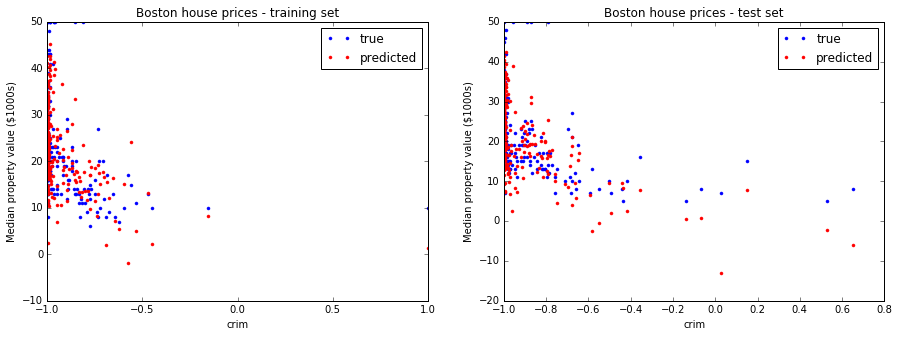

In [26]:
# Solution
max_feature = np.argmax(np.abs(w_unreg))
t_train_pred = np.dot(X_train, w_unreg)
t_test_pred = np.dot(X_test, w_unreg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(X_train[[max_feature]], t_train, 'b.', label='true')
ax.plot(X_train[[max_feature]], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel(X_train.columns[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(X_test[[max_feature]], t_test, 'b.', label='true')
ax.plot(X_test[[max_feature]], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel(X_test.columns[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

## Regression with regularization

Implement the regularized least squares regression to find the maximum likelihood solution $w_{reg}$ with regularizer $\lambda>0$. (Warning: the keyword ```lambda``` is a reserved word in Python).

In [10]:
# Solution

def w_ml_regularised(Phi, t, l):
    return np.dot(np.dot(np.linalg.inv(l * np.eye(Phi.shape[1]) + np.dot(Phi.T, Phi)), Phi.T), t)


Similar to the previous exercise, plot two figures showing the most important feature along with the label and prediction. Use $\lambda = 1.1$.

(4.7467361390129481, 5.2603798541769722)

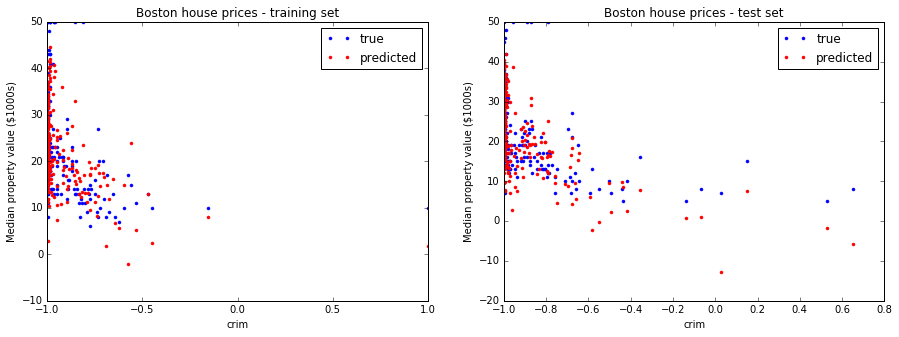

In [30]:
# Solution

w_reg = w_ml_regularised(X_train, t_train, 1.1)
max_feature = np.argmax(np.abs(w_reg))
t_train_pred = np.dot(X_train, w_reg)
t_test_pred = np.dot(X_test, w_reg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(X_train[[max_feature]], t_train, 'b.', label='true')
ax.plot(X_train[[max_feature]], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel(X_train.columns[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(X_test[[max_feature]], t_test, 'b.', label='true')
ax.plot(X_test[[max_feature]], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel(X_test.columns[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

rmse(X_train, t_train, X_test, t_test, w_reg)

## Analysis of results

Compare the RSME of regression with and without regularization. By also considering the plots, describe what you observe and explain your observations.

### Solution

The regularised model performs slightly worse on the training set (higher RMSE), but slightly better on the test set (lower RMSE). Including a regularisation term in the error function means the resulting model is less likely to overfit and therefore performs better on unseen test data. Note that the regularisation term is even more important when using polynomial basis functions (see below), as the higher dimensionality means there is more potential to overfit the training data.

## (optional) Exploration of basis functions and regularization parameter

The choice of basis function as well as the value of the regularization parameter $\lambda$ affects the performance of the predictor. Using the same training and test data as before, compute the different RMSE for:
* The standard basis (as done above)
* polynomial basis function of degree 2.
* $\lambda$ = [0.01, 0.1, 1, 10, 100]

In [31]:
# Solution

lambdas = [0, 0.01, 0.1, 1, 10, 100]
results = pd.DataFrame(columns=['rmse_train_linear', 'rmse_test_linear', 'rmse_train_quad', 'rmse_test_quad'], index=lambdas)

for l in lambdas:
    # RMSE with no transformation applied
    results.at[l,['rmse_train_linear', 'rmse_test_linear']] = \
        rmse(X_train, t_train, X_test, t_test, w_ml_regularised(X_train, t_train, l))
        
    # RMSE after applying quadratic basis function transformation to each data point
    Phi_train = np.array([phi_quadratic(x) for i,x in X_train.iterrows()])
    Phi_test = np.array([phi_quadratic(x) for i,x in X_test.iterrows()])
    results.at[l,['rmse_train_quad', 'rmse_test_quad']] = \
        rmse(Phi_train, t_train, Phi_test, t_test, w_ml_regularised(Phi_train, t_train, l))

results

,rmse_train_linear,rmse_test_linear,rmse_train_quad,rmse_test_quad
0.00,4.73849,5.27922,2.43924,5.6817
0.01,4.73849,5.27899,2.5093,3.51985
0.10,4.73857,5.27695,2.57043,3.33795
1.00,4.74539,5.26159,2.76864,3.33788
10.00,5.05532,5.35731,3.40314,3.725
100.00,7.57274,7.39682,4.93107,4.86188
